<a href="https://colab.research.google.com/github/Desmondonam/DS_Python/blob/main/Time_Series_Decomposition_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Decomposition

Here we try to understand 3 major components of time series data

- Trend

Trend long term pattern in a given direction so like increase or decrease or constant.  

Upward trend

Downward trend

Horizontal trend
- Seasonality

periodic patterns that are occuring at circles
STL - Seasonal Decomposition of time series
Or seasonal differencing

- Noise

Random and irregular fluctuation that occurs in the data.
Handling the noise - techniques
Smoothing Technique
Filtering -
Seasonal Decomposition
Outlier detection and treatment -
Modelling approach - robust model - regression, time series model ARIMA

## Decomposing

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

>Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.

>Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.

>Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

## Additive or Multiplicative Decomposition?

To achieve successful decomposition, it is important to choose between the additive and multiplicative models, which requires analyzing the series. For example, does the magnitude of the seasonality increase when the time series increases?

![](http://kourentzes.com/forecasting/wp-content/uploads/2014/11/mseas.fig1_.png)


Fortunately, `statsmodels` provides the convenient `seasonal_decompose` function to perform such decomposition out of the box. Details of this function are available [here](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

Let's use this function to perform following tasks:
1. Import `seasonal_decompose` from statsmodels.
2. Apply `seasonal_decompose` to log transformed TS.
3. Plot the trend, seasonality and residual.

In [2]:
## Importing the libraries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
from pylab import rcParams

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

In [11]:
# You can access the data here
url = 'https://raw.githubusercontent.com/Desmondonam/time_series_notebooks/master/time_series_from_scratch/data.csv'

# import and visualise data
parser = lambda dates: pd.datetime.strptime(dates,'%b-%Y')

# for one to read the data you will pass the url like this
url = 'https://raw.githubusercontent.com/Desmondonam/time_series_notebooks/master/time_series_from_scratch/data.csv'
data = pd.read_csv(url)
data.head()




data = pd.read_csv('data.csv',
                   engine='python',parse_dates=[0],
                   index_col = 'Time',
                   date_parser = parser)



In [12]:
# The data starts from Jan 1976 to Dec 2018.
data.head()

,Total arrivals
Time,
1976-01-01,203000
1976-02-01,137000
1976-03-01,119000
1976-04-01,102100
1976-05-01,129000


In [13]:
data.tail()

,Total arrivals
Time,
2018-08-01,1718600
2018-09-01,1722000
2018-10-01,1963700
2018-11-01,1668000
2018-12-01,1853600


In [14]:
def show_plot(
    data,
    figsize=(15, 10),
    color="blue",
    linestyle="-",
    xlabel="Time",
    ylabel="Total arrivals",
    label=None,
):
    plt.figure(figsize=figsize)
    plt.plot(data.index, data, color=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)

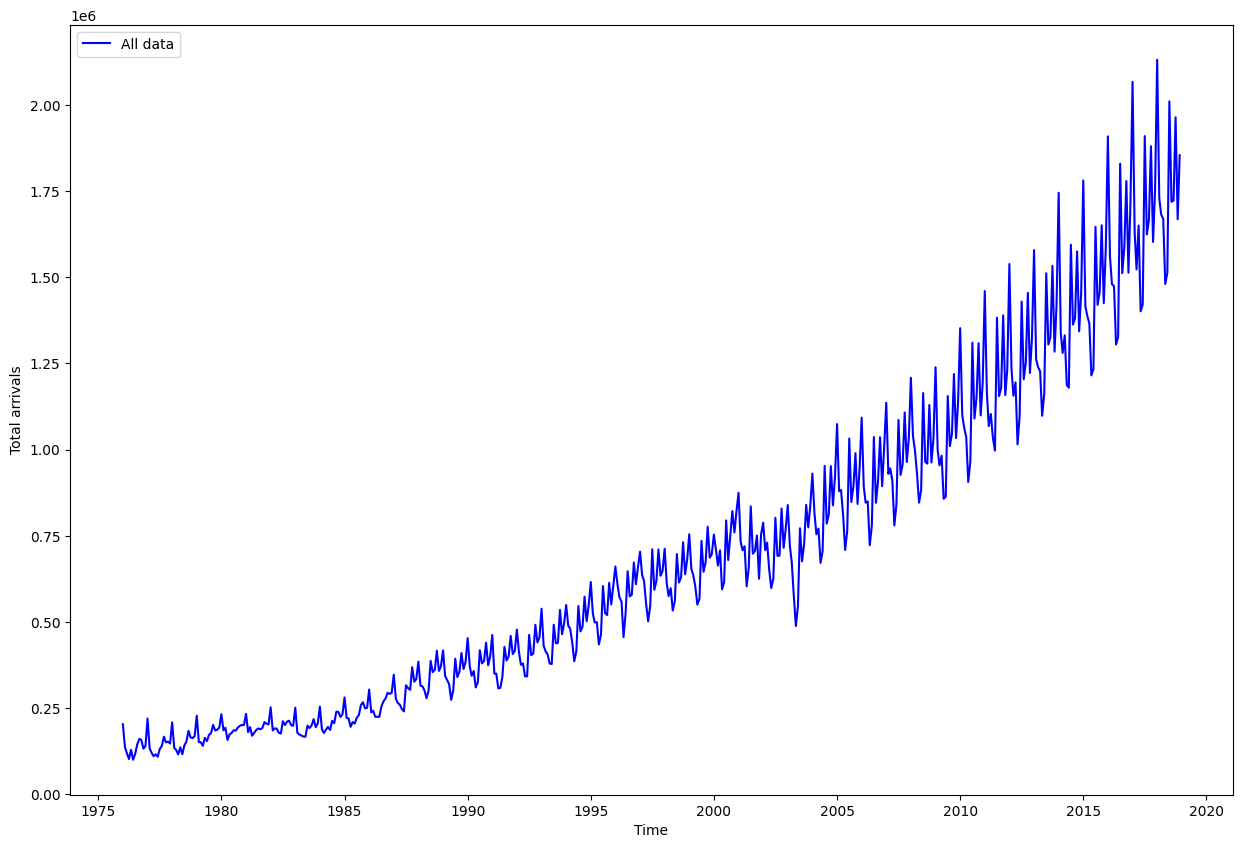

In [15]:
show_plot(data,label = 'All data')

#### Takeaway from the plot:
1. There is a clear trend and strong strong seasonal pattern;
2. There are some irregular patterns around 1980-1985 and around 2004.

Therefore, the data is suitable for decomposition model. The iregular patterns (outliers) can be either replaced by predicted values, or be avoided in training. In this example, I only train and test the values after 2005.

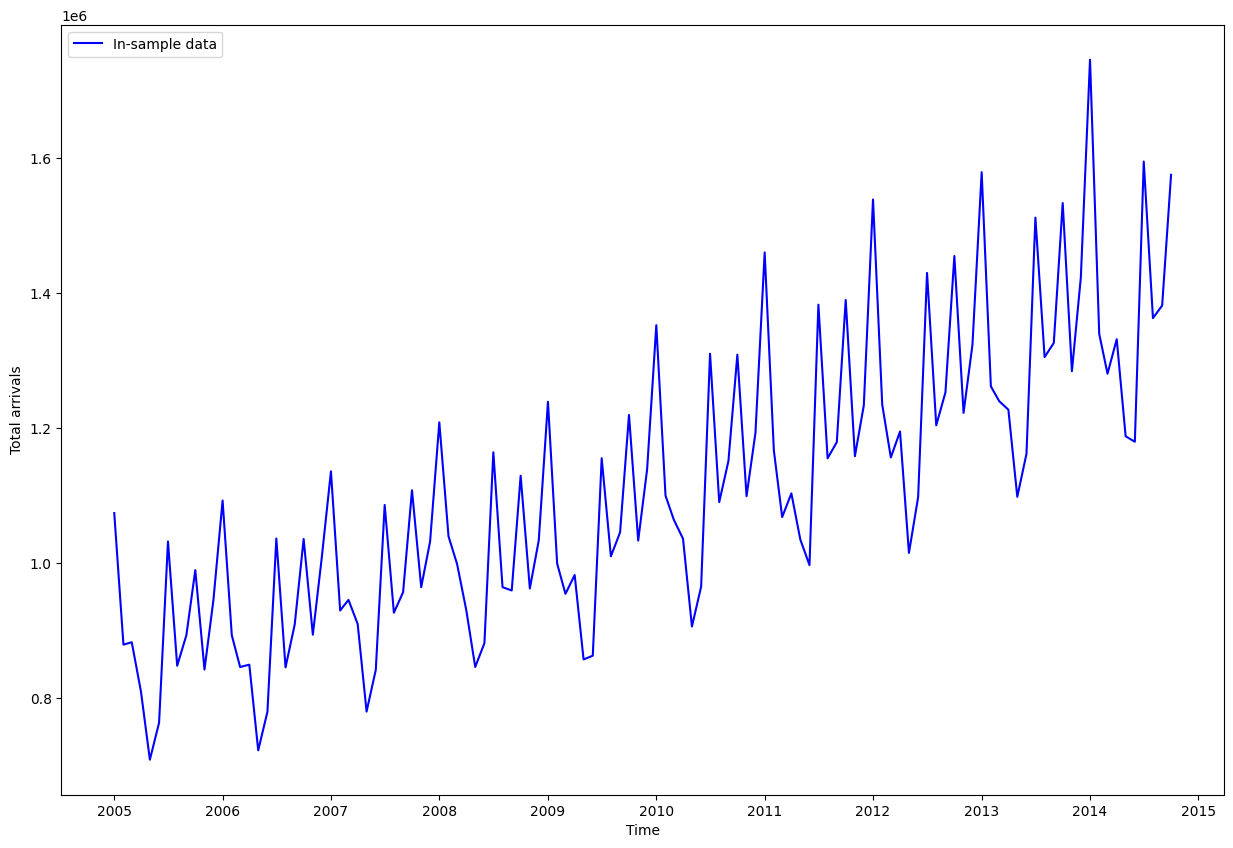

In [16]:
# cut down samples and train-test split.
def year_cut(data,time):
    '''
    data: df, (n,1), index type must be DatetimeIndex, must be 1
    time: str,'MMM-YYYY'. Must comply with date form in data.
    '''
    return data[time:]

def tt_split(data,seperator=0.7):
    '''
    Input:
        data: df, (n,1)
        seperator: float, (0,1). string, 'MMM-YYYY'.
    Output:
        trainin, test: df
    '''
    try:
        n = int(data.shape[0]*seperator)
        return data[:n+1],data[n+1:]
    except:
        return data[:seperator],data[seperator:]

data_ten_y = year_cut(data,'Jan-2005') # Cut the original data from Jan 2005.
# First 70% data is used as in-sample data, the rest is out-of-sample.
train, test = tt_split(data_ten_y)
show_plot(train,label = 'In-sample data')

In [17]:
train.head()

,Total arrivals
Time,
2005-01-01,1073800
2005-02-01,879100
2005-03-01,882600
2005-04-01,809600
2005-05-01,708700


In [18]:
train.tail()

,Total arrivals
Time,
2014-06-01,1179400
2014-07-01,1594100
2014-08-01,1362400
2014-09-01,1381000
2014-10-01,1574500


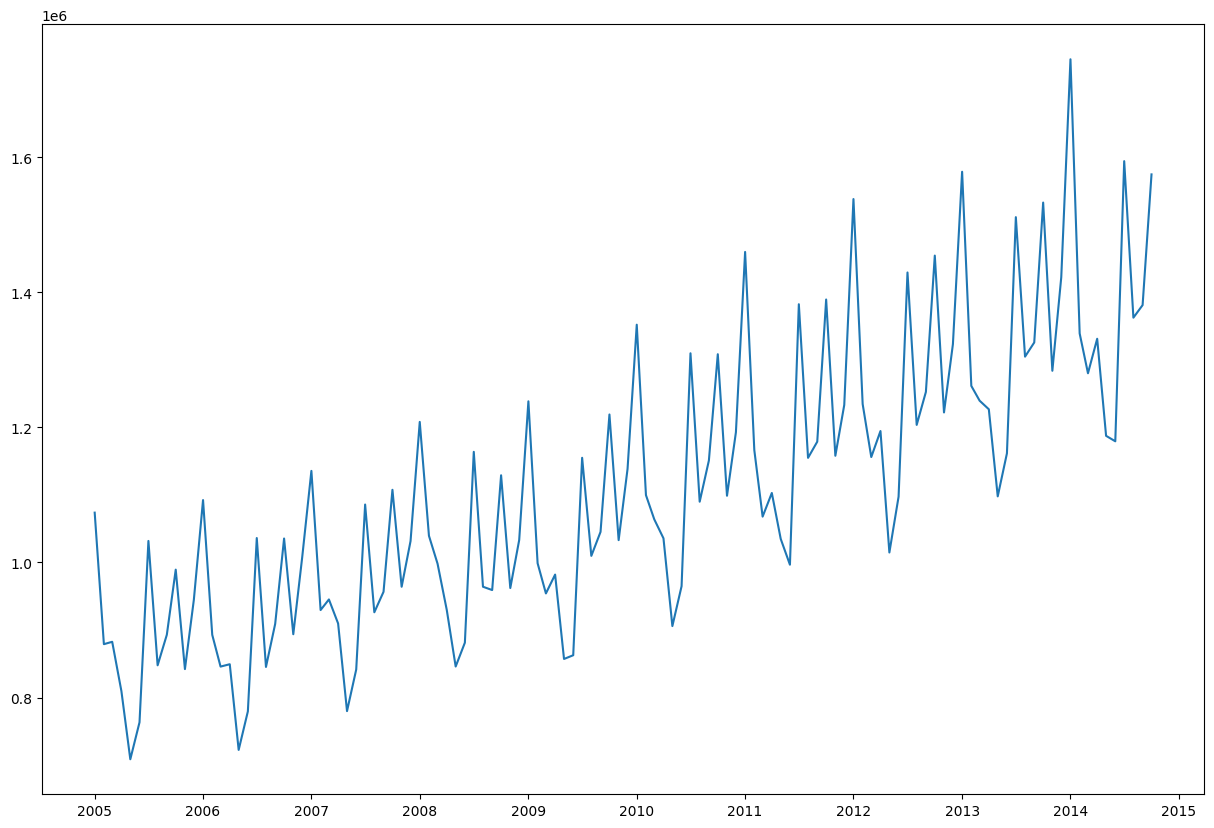

In [19]:
plt.plot(train)

## decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
result = seasonal_decompose(train, model='additive')

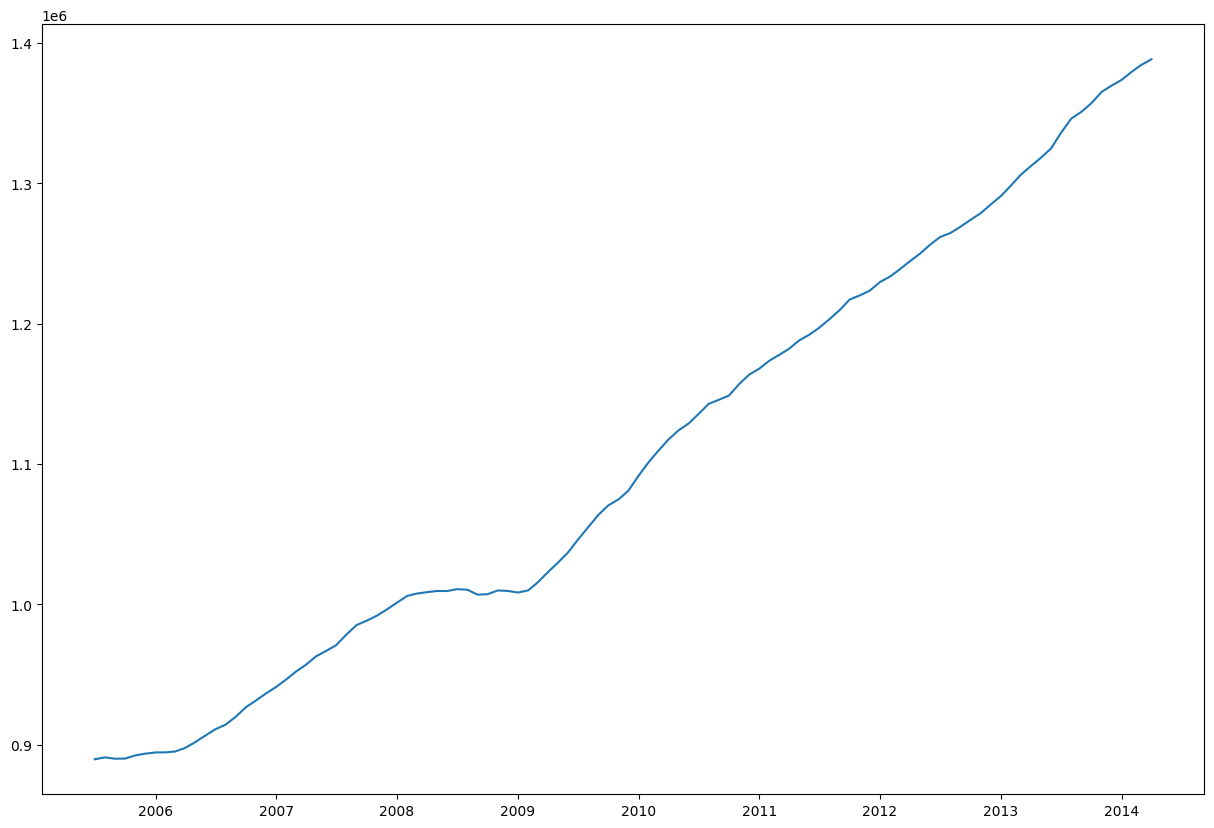

In [23]:
plt.plot(result.trend)

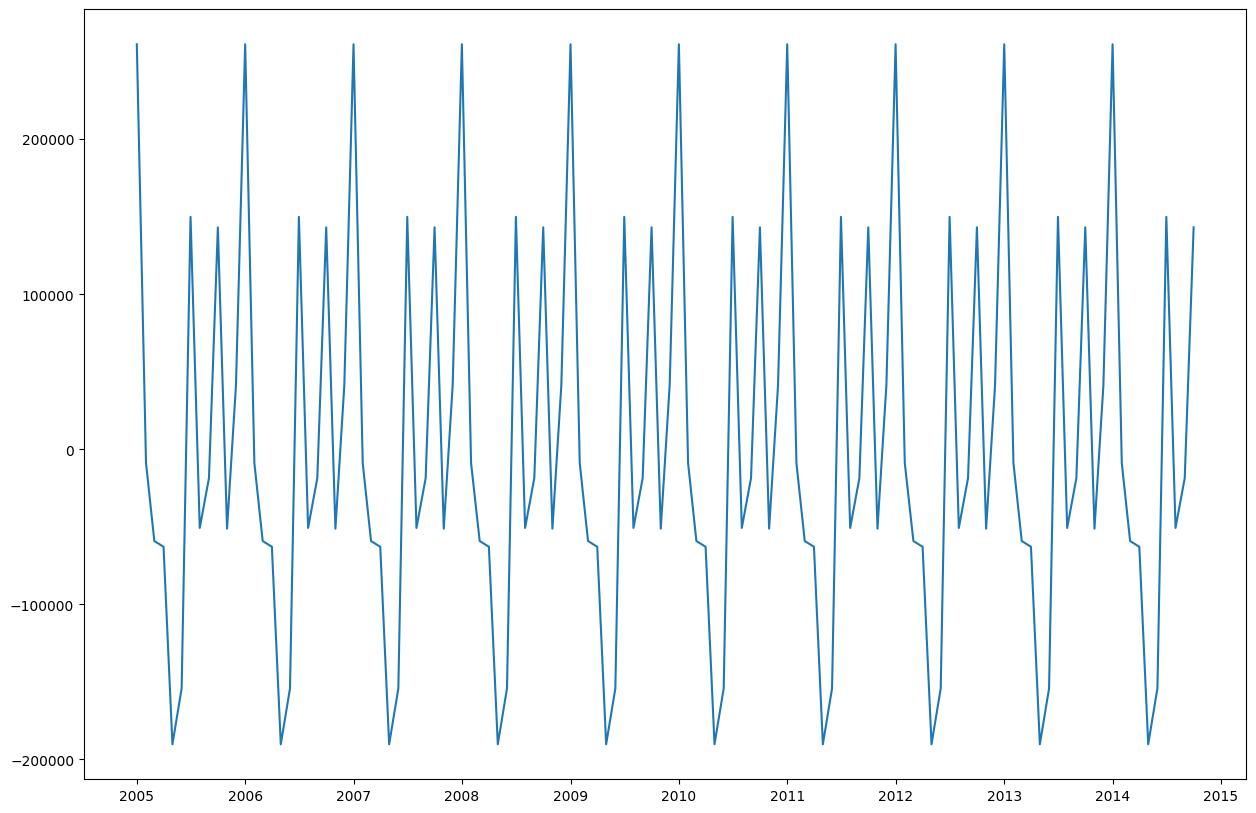

In [24]:
plt.plot(result.seasonal)

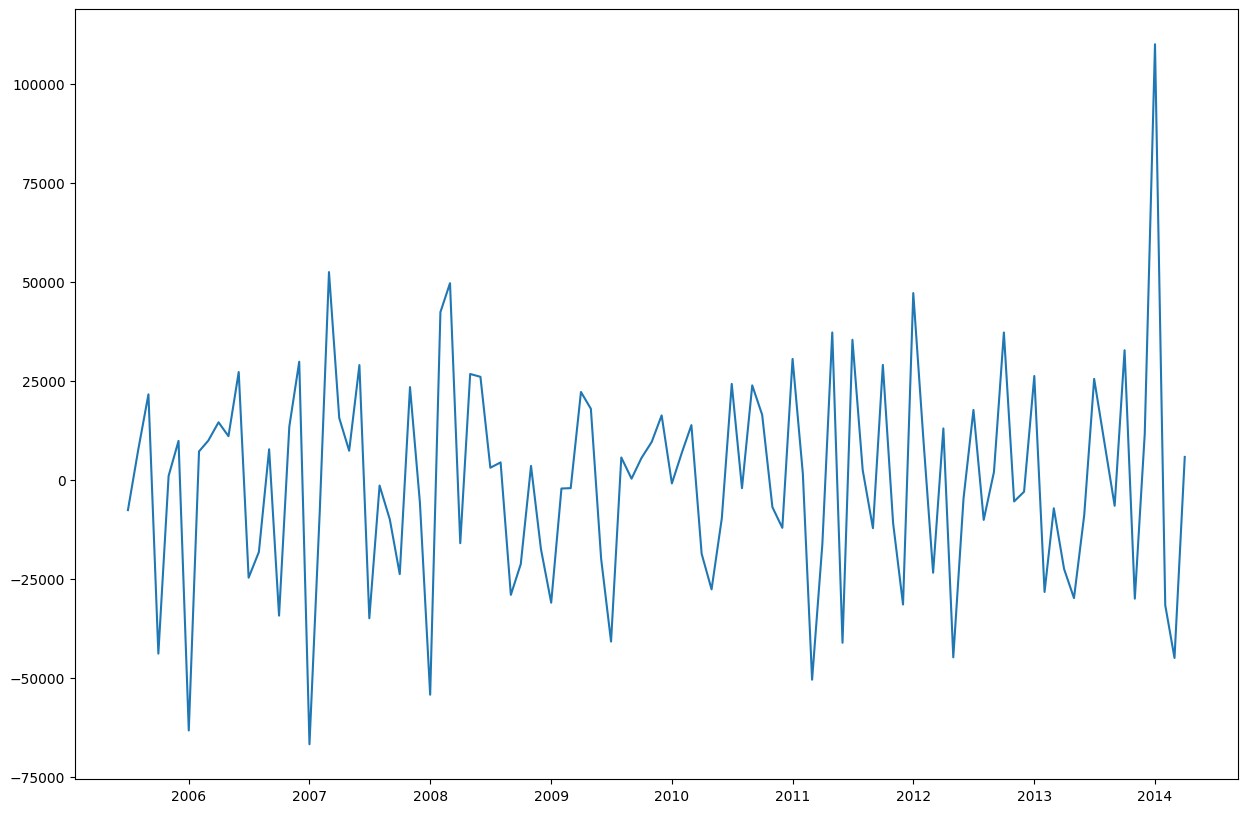

In [25]:
plt.plot(result.resid)

In [26]:
order = 2
coef = np.polyfit(np.arange(len(train['Total arrivals'])),
                  train['Total arrivals'].values.ravel(),
                  order)
coef

array([1.90540432e+01, 2.61154811e+03, 8.67857588e+05])

In [27]:
poly_mdl = np.poly1d(coef)
poly_mdl

poly1d([1.90540432e+01, 2.61154811e+03, 8.67857588e+05])

In [28]:
trend = pd.Series(data = poly_mdl(np.arange(len(train['Total arrivals']))),
                  index = train.index)

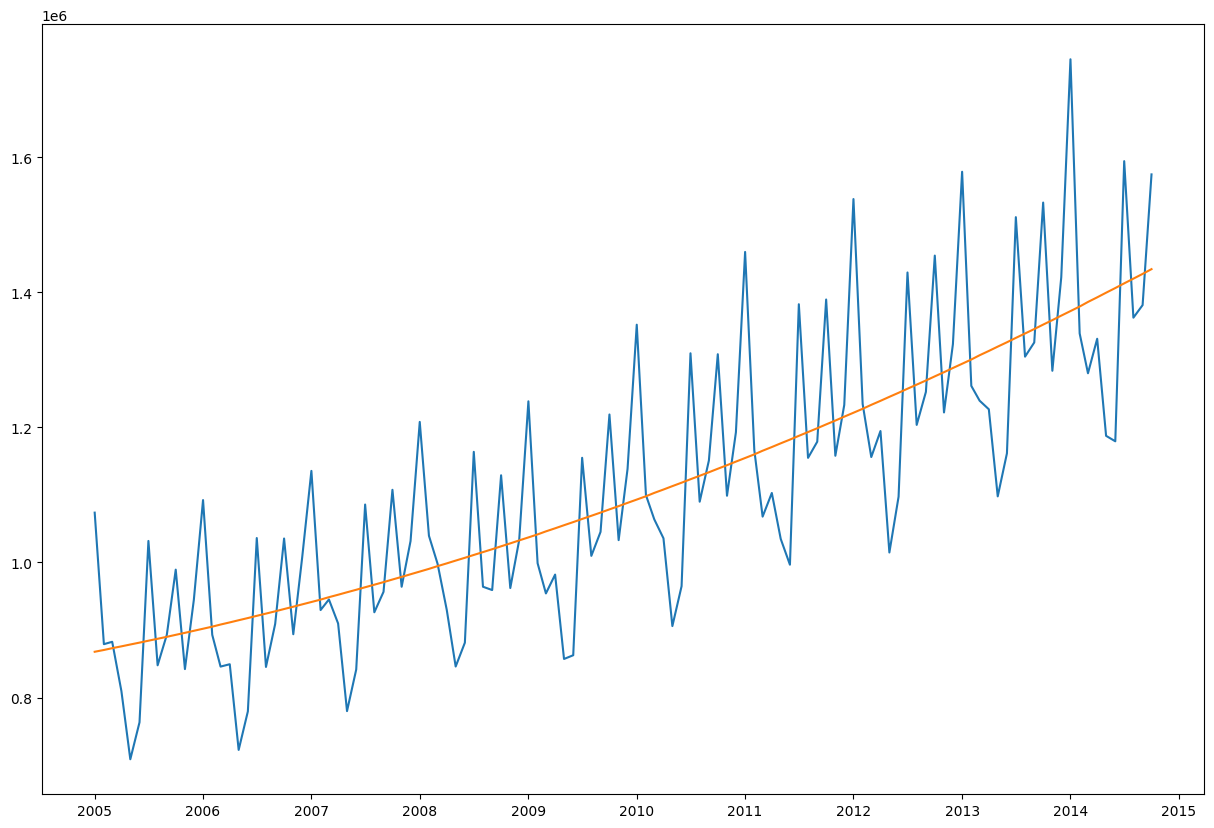

In [29]:
plt.plot(train)
plt.plot(trend)
plt.show()

In [30]:
detrended = train['Total arrivals'] - trend

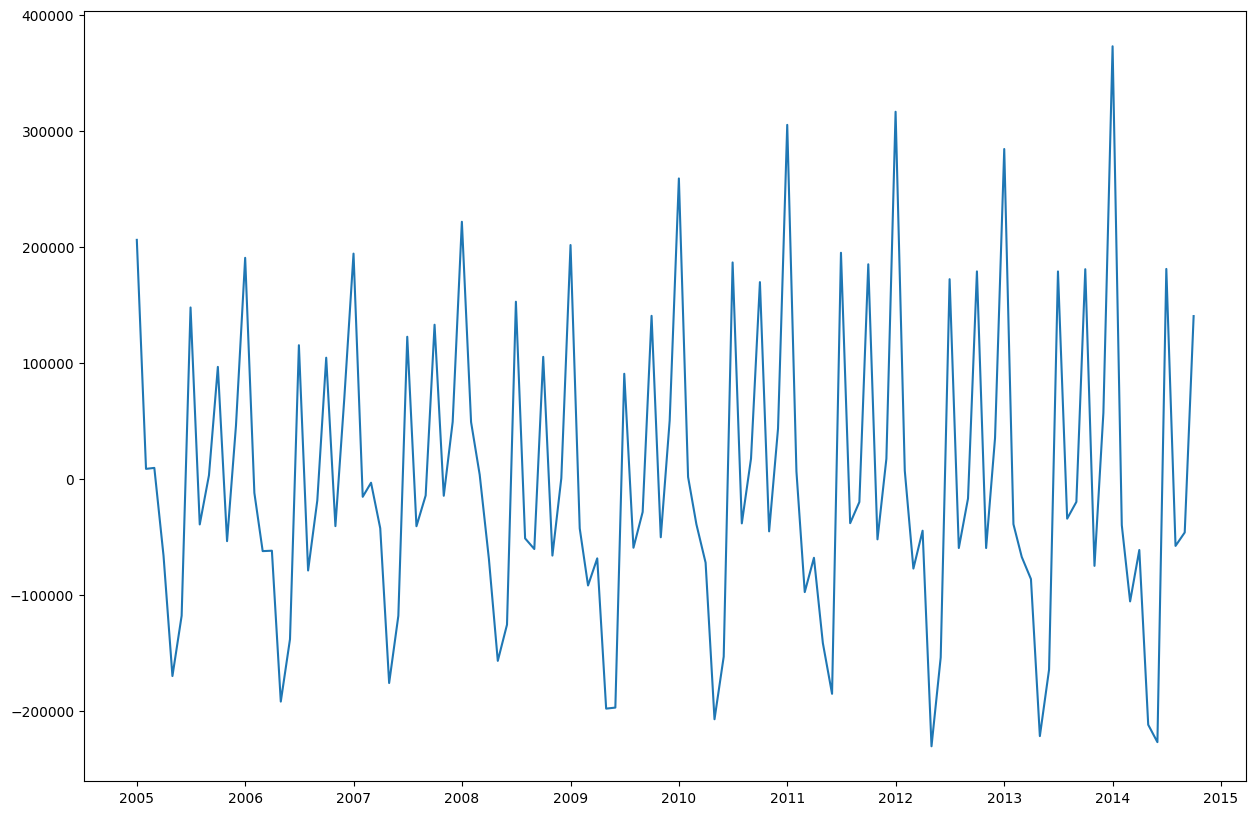

In [31]:
plt.plot(detrended)

In [32]:
seasonal = detrended.groupby(by = detrended.index.month).mean()

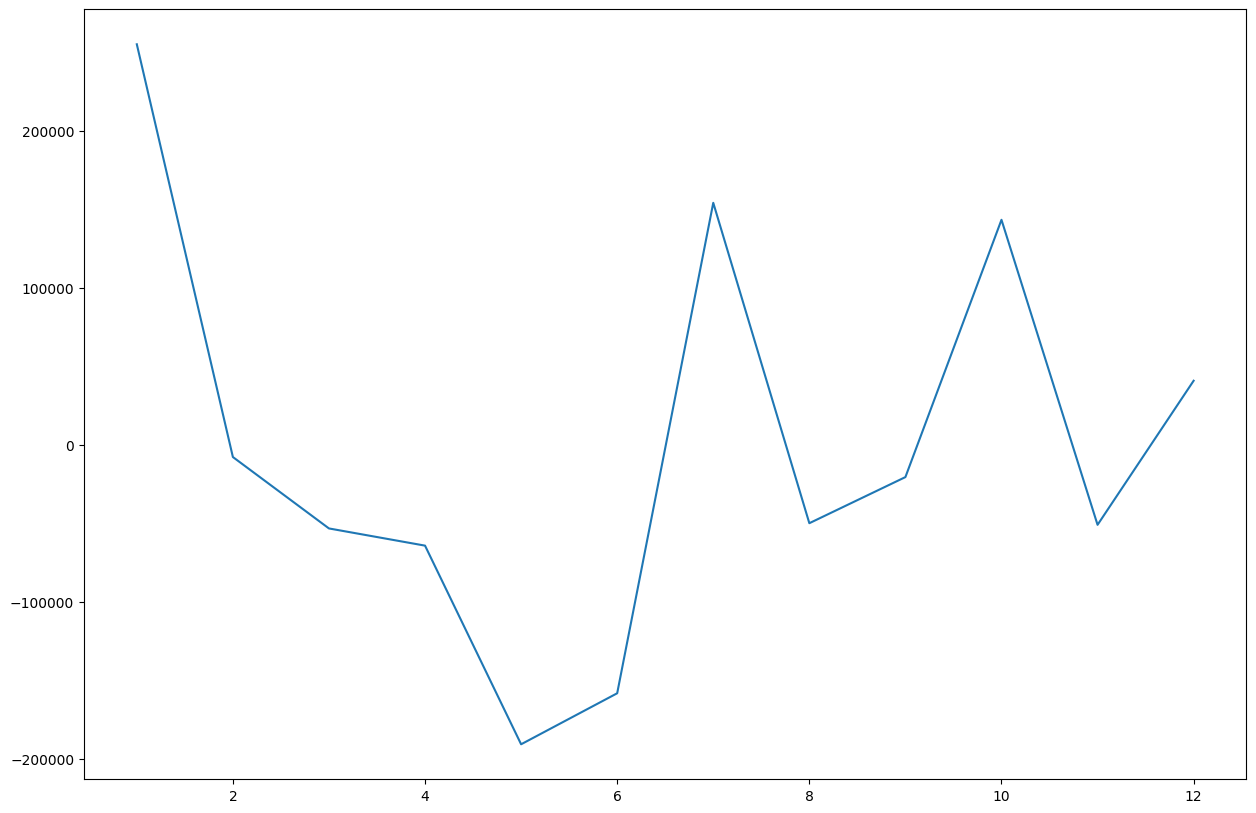

In [33]:
plt.plot(seasonal)

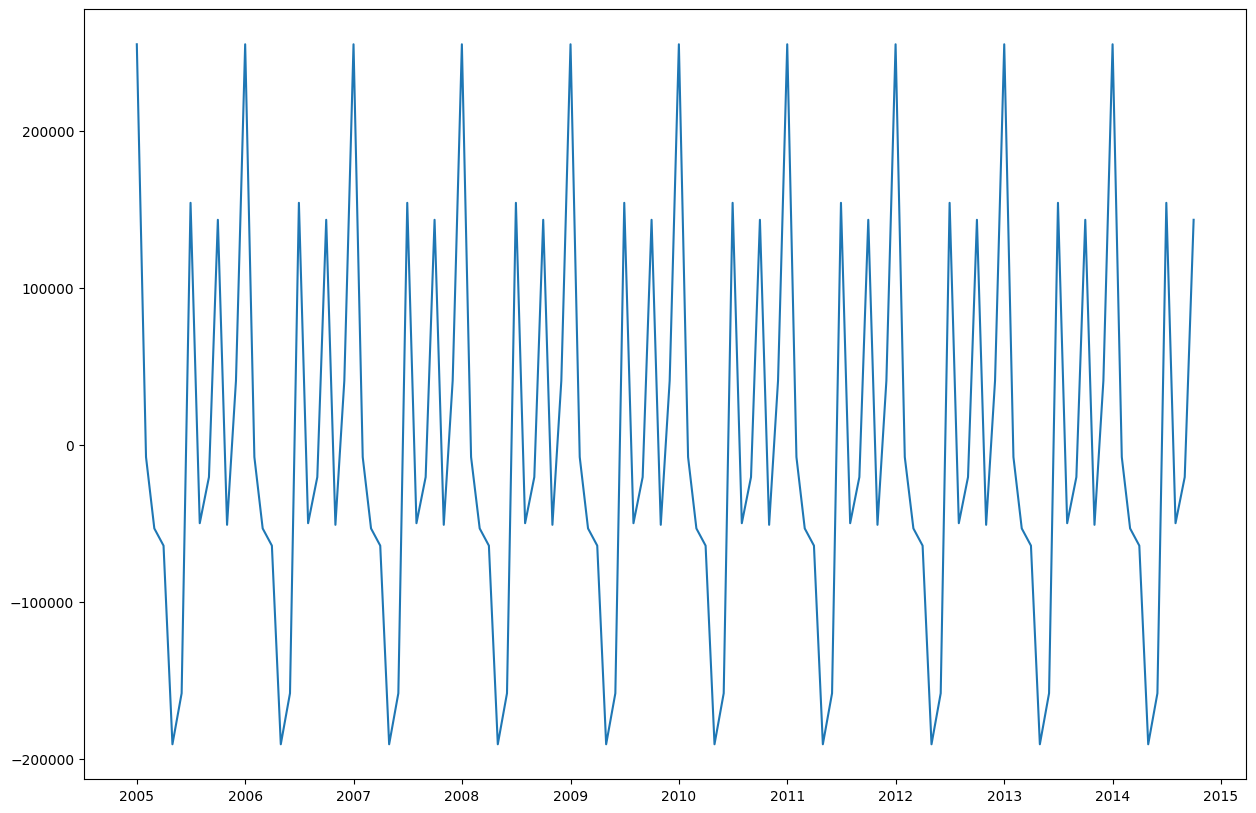

In [34]:
col = 'Total arrivals'
seasonal_component = copy.deepcopy(train)
for i in seasonal.index:
    seasonal_component.loc[seasonal_component.index.month == i, col] = seasonal.loc[i]
plt.plot(seasonal_component)

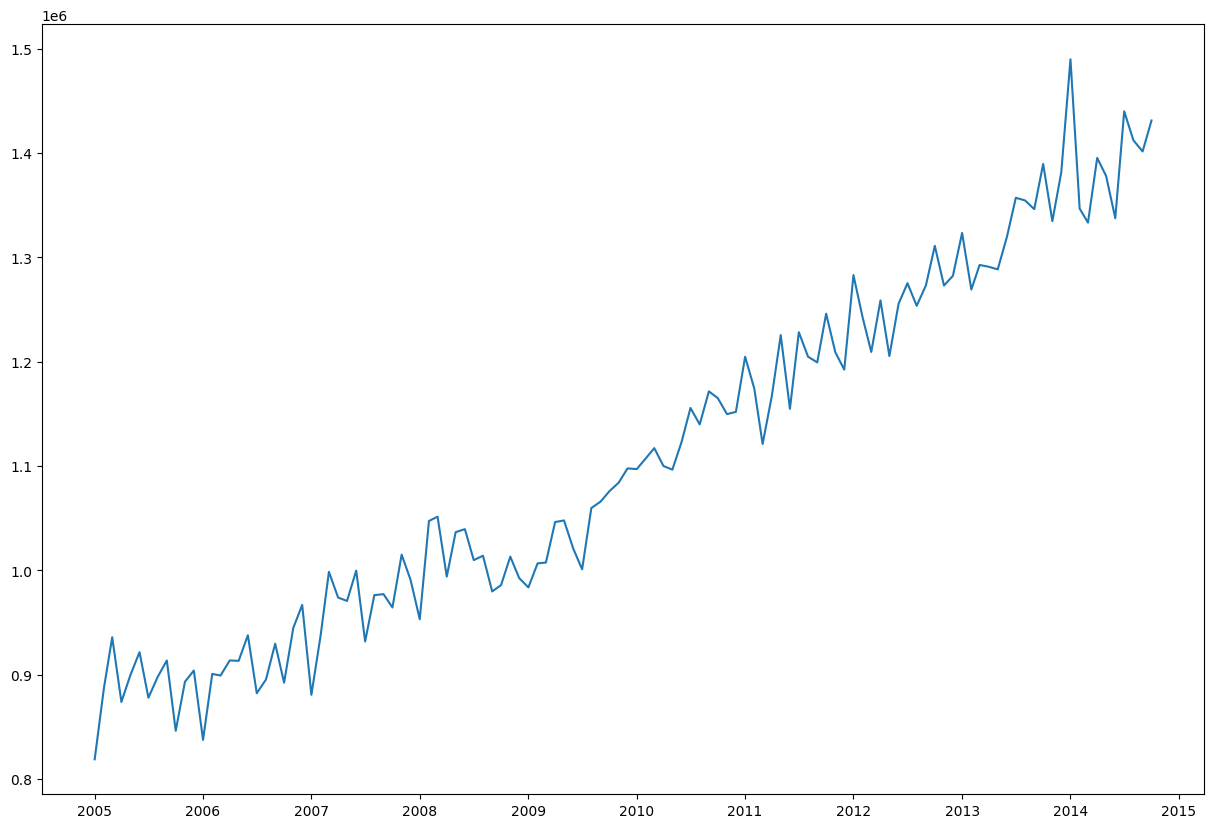

In [35]:
deseasonal = train - seasonal_component
plt.plot(deseasonal)

In [36]:
coef = np.polyfit(np.arange(len(deseasonal)), deseasonal['Total arrivals'], order)
coef

array([1.83276298e+01, 2.70780761e+03, 8.65555196e+05])

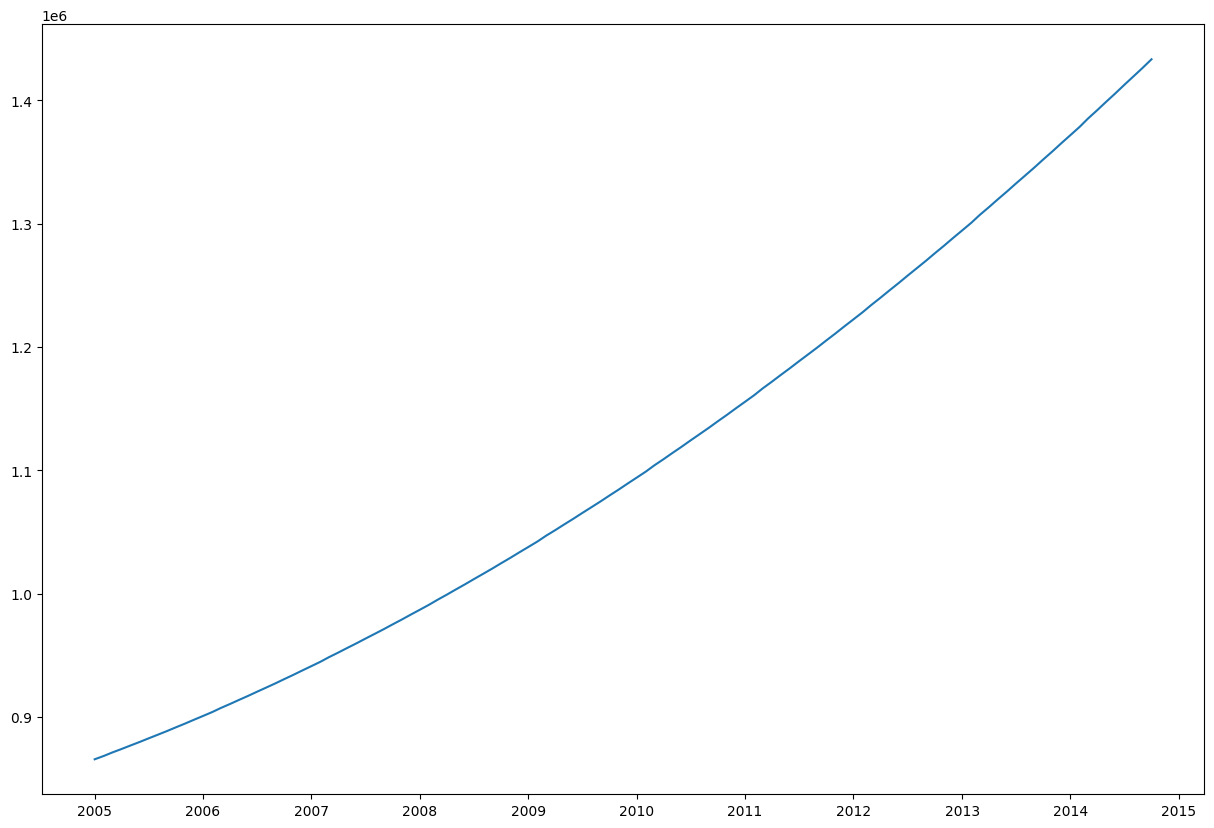

In [37]:
poly_mdl = np.poly1d(coef)
trend_comp = pd.DataFrame(data = poly_mdl(np.arange(len(train['Total arrivals']))),
                          index = train.index,
                          columns=['Total arrivals'])
plt.plot(trend_comp)

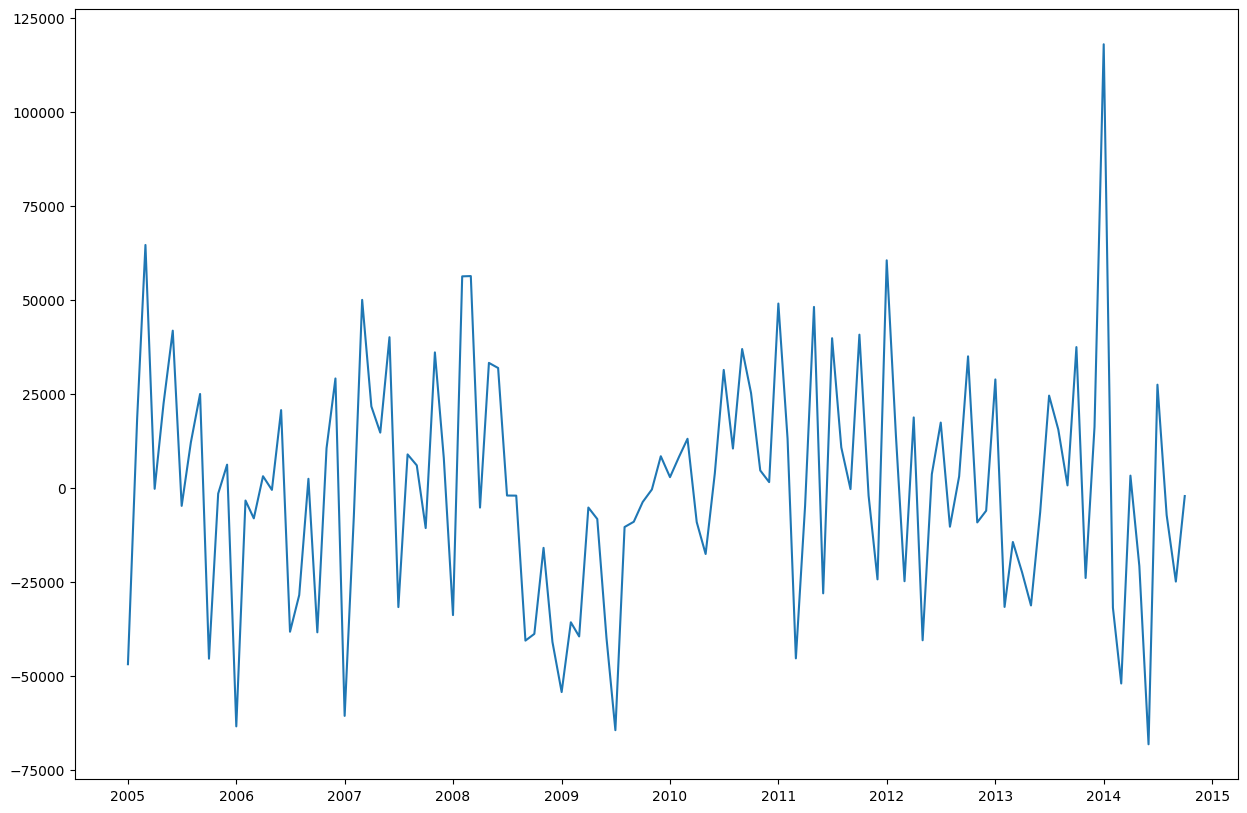

In [38]:
residual = train - seasonal_component - trend_comp
plt.plot(residual)

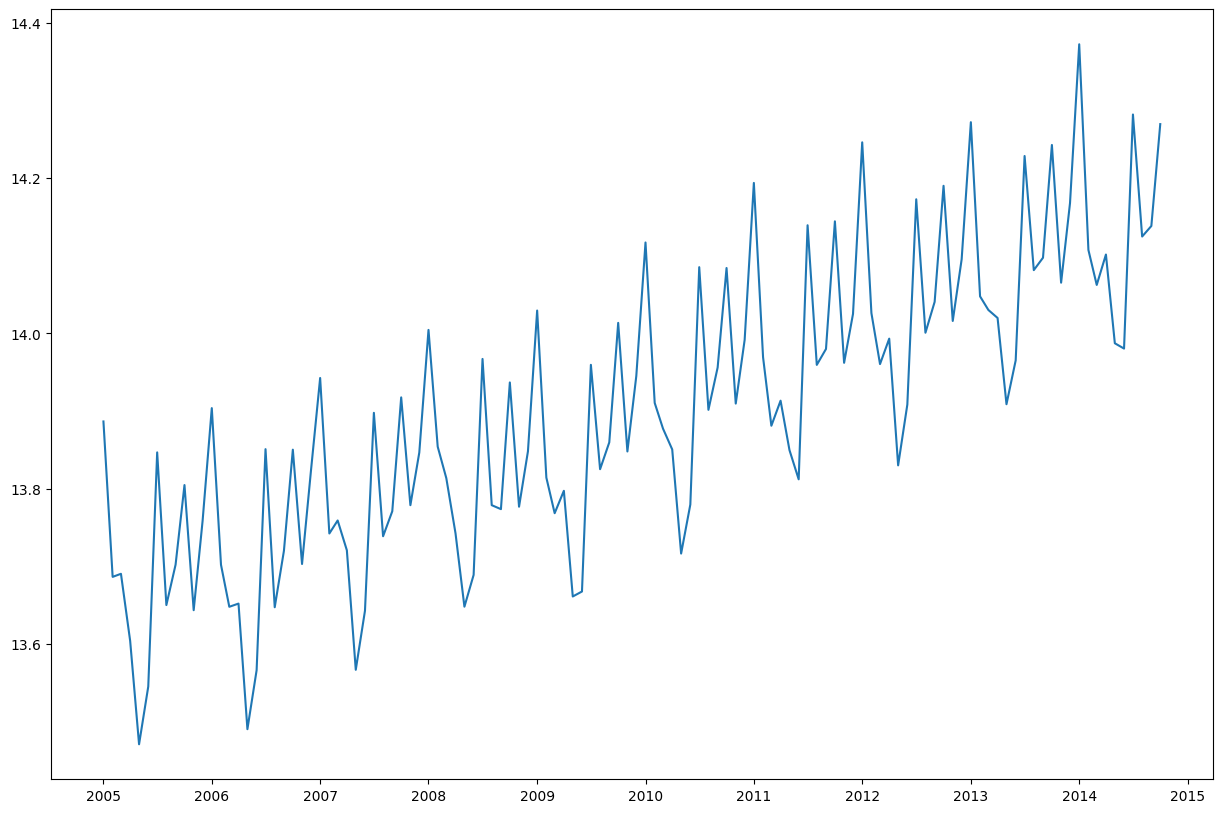

In [39]:
plt.plot(np.log(train))

In [ ]:
result_log = seasonal_decompose(np.log(train), model='additive', freq=30)

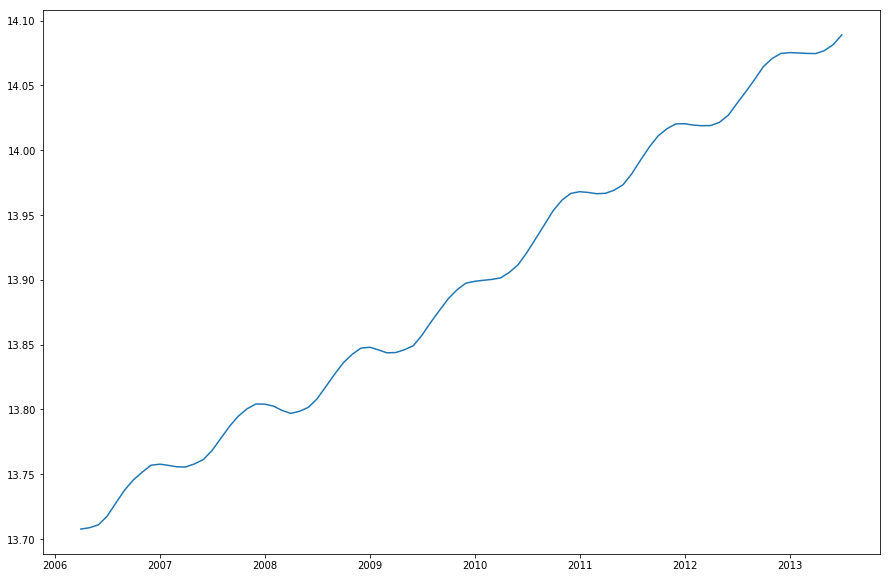

In [ ]:
plt.plot(result_log.trend)

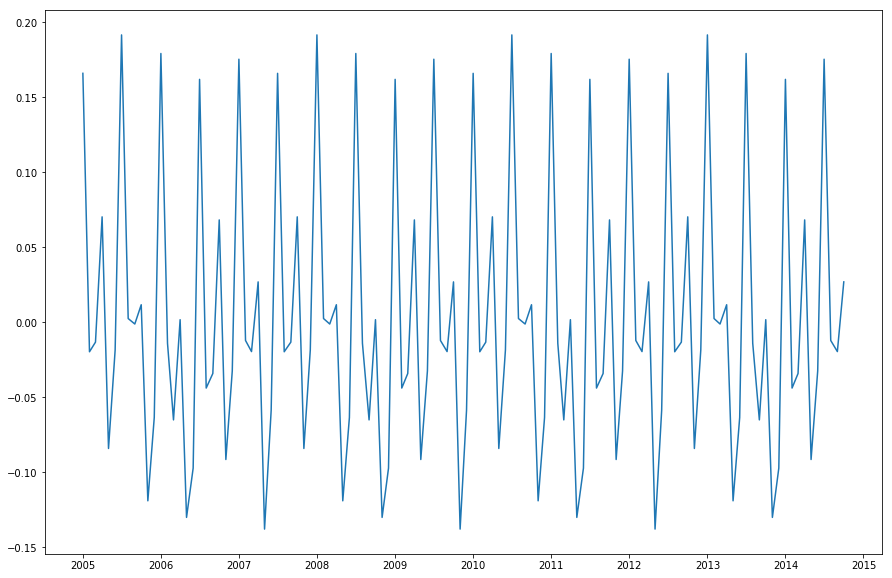

In [ ]:
plt.plot(result_log.seasonal)

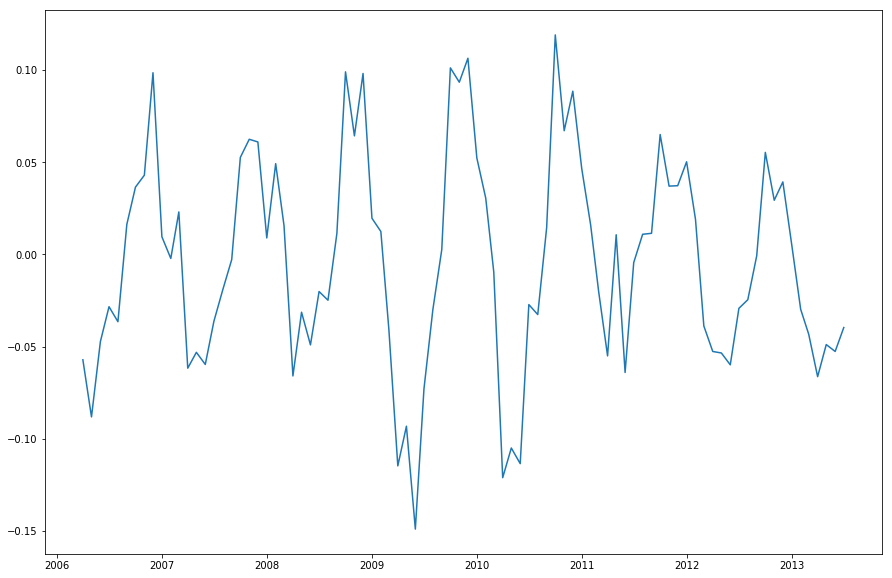

In [ ]:
plt.plot(result_log.resid)

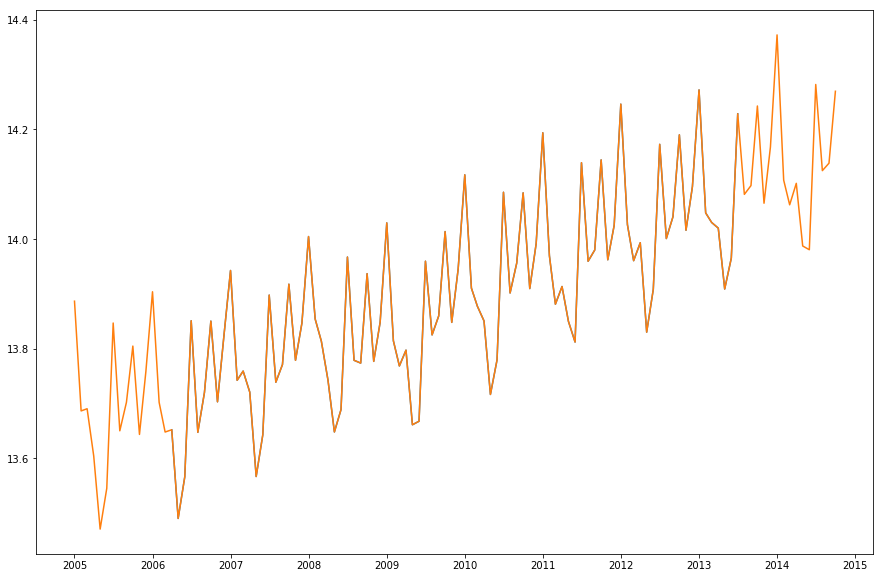

In [ ]:
plt.plot(result_log.resid + result_log.trend + result_log.seasonal)
plt.plot(np.log(train))
plt.show()

### Assignment 1. - 29th July

With the in built data set of Airpassangers, produce EDA plots

1. Seasonal Plot
2. Box Plot
3. Histogram and Density Plot
4. Autocorrelation Plot
5. Seasonal Decomposition Plot


### Assignment 2 - 30th July

#### Assignment: Time Series Decomposition and Visualization

Objective: Perform time series decomposition on a real-world dataset and visualize the decomposed components.

### Steps:

1. Choose a real-world time series dataset of your interest. You can explore public datasets or use a dataset from your domain or interests (e.g., monthly sales data, temperature data, stock prices). - Kaggle, data.gov, data.world,

2. Load and preprocess the dataset:

Handle missing values (if any).
Set a proper datetime index.
Perform time series decomposition using seasonal_decompose from statsmodels.

3. Visualize the decomposed components:

Create a subplot to display the original time series and the decomposed components (trend, seasonality, residuals) separately.
Customize the plot to improve readability (e.g., labels, colors, legends).
4. Analyze and interpret the results:

Examine the trend component to identify the long-term movement or direction of the time series.
Observe the seasonality component to understand the recurring patterns at regular intervals.
Analyze the residuals to check for random fluctuations and unexplained variance.
Optionally, reconstruct the time series from the decomposed components and compare it with the original data to assess the accuracy of the decomposition.

5. Include explanatory comments in your code to describe each step and your observations.

Bonus: If you want to challenge yourself further, try experimenting with different decomposition models (multiplicative vs. additive) and see how the results differ.